<a href="https://colab.research.google.com/github/manjitullal/foursquare/blob/master/RNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Temporal and Spatial analysis of events data using LSTM**



**Dataset:** foursquare

**Aim:** to predict future location and time of user given the historical sequences of location and time .

An analogy for the aim is , predicting the next word in a sentence. 


**Contents:**
***
1. Data pre processing
2. Encoding
3. Modeling
4. Training

# **1. Data pre processing**


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf


from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data



torch.manual_seed(1)

1. **Check for GPU**
---
This code presently does not use GPU. This will later be modified to use one.


In [2]:
#check the devices available

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13359404271917426863
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3441581282584748557
physical_device_desc: "device: XLA_CPU device"
]


In [3]:
#check if the gpu is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
#the GPU may not be available at the moment

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')


GPU device not found


In [5]:
#dataset is in the google drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
#my google drive path

!ls "/content/drive/My Drive/dataset/foursquare"
path = "/content/drive/My Drive/dataset/foursquare"

Checkin.txt	 UserFriends.txt    VenueRating.txt
Description.txt  VenueCategory.txt  Venue.txt


2. **Load dataset.** 
---
Dataset, consists of 5 tables. `Checkin` table has the event details

In [7]:
%%time
Checkin_columns = ['UserID','VenueID','Year','Month','Date','Hour']
Checkin = pd.read_csv(path+'/Checkin.txt', sep=',', skiprows=1, names=Checkin_columns)

CPU times: user 712 ms, sys: 143 ms, total: 856 ms
Wall time: 1.21 s


In [8]:
%%time

Venue_columns = ['VenueID','VenueName','Latitude','Longitude','CategoryID']
Venue = pd.read_csv(path+'/Venue.txt', sep=',', error_bad_lines=False,skiprows=1,names=Venue_columns)

VenueCategory_columns = ['CategoryID','CategoryName','ParentCategoryID']
VenueCategory = pd.read_csv(path+'/VenueCategory.txt', sep=',',error_bad_lines=False,skiprows=1,names=VenueCategory_columns)

VenueRating_columns = ['VenueID','Rating']
VenueRating = pd.read_csv(path+'/VenueRating.txt', sep=',',error_bad_lines=False,skiprows=1,names=VenueRating_columns)

UserFriends = pd.read_csv(path+'/UserFriends.txt', sep=',') 

all_tables = [Checkin,Venue,VenueCategory,VenueRating,UserFriends]
all_tables_string = ['Checkin','Venue','VenueCategory','VenueRating','UserFriends']

CPU times: user 999 ms, sys: 92.4 ms, total: 1.09 s
Wall time: 1.89 s


In [9]:
Checkin.head()

,UserID,VenueID,Year,Month,Date,Hour
0,u1302,v47,2012,2,24,11
1,u45,v132,2012,2,24,11
2,u24844,v86,2012,2,24,11
3,u896,v248,2012,2,24,11
4,u5020,v29,2012,2,24,11


In [10]:
#stats of the data 

def _describe(data):
    print(f" Number of rows: {data.shape[0]}")
    print(f" Number of columns: {data.shape[1]}")
    print(f" Number of null values: {np.sum(data.isnull().sum())}")
    print("The columns that have null values")
    print(pd.DataFrame(data.isnull().sum()).T)
    
for index,table in enumerate(all_tables):
    print(f"Details of table {all_tables_string[index]}")
    print("")
    _describe(table)
    print("")

Details of table Checkin

 Number of rows: 1276988
 Number of columns: 6
 Number of null values: 0
The columns that have null values
   UserID  VenueID  Year  Month  Date  Hour
0       0        0     0      0     0     0

Details of table Venue

 Number of rows: 85928
 Number of columns: 5
 Number of null values: 14
The columns that have null values
   VenueID  VenueName  Latitude  Longitude  CategoryID
0        0         12         2          0           0

Details of table VenueCategory

 Number of rows: 394
 Number of columns: 3
 Number of null values: 0
The columns that have null values
   CategoryID  CategoryName  ParentCategoryID
0           0             0                 0

Details of table VenueRating

 Number of rows: 68178
 Number of columns: 2
 Number of null values: 96
The columns that have null values
   VenueID  Rating
0       96       0

Details of table UserFriends

 Number of rows: 1366388
 Number of columns: 2
 Number of null values: 0
The columns that have null valu

3. **Model for one user** (for testing), hence we will filter the data for one user, eventually this will be extended for all users

In [11]:
#filter data for one user 

Checkin_u1205 = Checkin[Checkin.UserID == 'u1205']
Checkin_u1205.head()

,UserID,VenueID,Year,Month,Date,Hour
2723,u1205,v73805,2012,2,25,9
3817,u1205,v9884,2012,2,25,11
4739,u1205,v3906,2012,2,25,13
5904,u1205,v10373,2012,2,25,15
6840,u1205,v9884,2012,2,25,17


In [12]:
# drop userid as that is not useful now, since there is only one user 

Checkin_u1205.drop(['UserID'], axis=1, inplace=True)

#renaming column Date to Day
Checkin_u1205.rename(columns={"Date":"Day"}, inplace=True)
Checkin_u1205.head()

,VenueID,Year,Month,Day,Hour
2723,v73805,2012,2,25,9
3817,v9884,2012,2,25,11
4739,v3906,2012,2,25,13
5904,v10373,2012,2,25,15
6840,v9884,2012,2,25,17


In [13]:
# create a new column, datetime to sort the events 

%%time
Checkin_u1205['Datetime'] = pd.to_datetime(Checkin_u1205[['Year', 'Month', 'Day', 'Hour']])
Checkin_u1205['Hour_mins'] = Checkin_u1205.Hour.values*60

Checkin_u1205.head()

CPU times: user 22.7 ms, sys: 4.3 ms, total: 27 ms
Wall time: 92.4 ms


In [14]:
# sort based on datetime
Checkin_u1205.sort_values(by='Datetime',inplace=True)

Checkin_u1205.head()

,VenueID,Year,Month,Day,Hour,Datetime,Hour_mins
2723,v73805,2012,2,25,9,2012-02-25 09:00:00,540
9154,v40561,2012,2,25,9,2012-02-25 09:00:00,540
3817,v9884,2012,2,25,11,2012-02-25 11:00:00,660
10664,v1743,2012,2,25,11,2012-02-25 11:00:00,660
4739,v3906,2012,2,25,13,2012-02-25 13:00:00,780


In [15]:
# from the above, we can see that for some reason there are 2 duplicate timestamps with different venues
# it is not possible for a person to be at different location at the same time, so removing the rows with duplicate time stamps
# the category of the venues is hierarchical, however for there appears no link between the venues

Checkin_u1205_nodup = Checkin_u1205.drop_duplicates('Datetime')

In [16]:
print("Rows in Checkin_u1205: ", Checkin_u1205.shape[0])
print("Rows in Checkin_u1205_nodup: ", Checkin_u1205_nodup.shape[0])

Rows in Checkin_u1205:  1303
Rows in Checkin_u1205_nodup:  1227


In [17]:
Checkin_u1205_nodup.iloc[:20]

,VenueID,Year,Month,Day,Hour,Datetime,Hour_mins
2723,v73805,2012,2,25,9,2012-02-25 09:00:00,540
3817,v9884,2012,2,25,11,2012-02-25 11:00:00,660
4739,v3906,2012,2,25,13,2012-02-25 13:00:00,780
5904,v10373,2012,2,25,15,2012-02-25 15:00:00,900
6840,v9884,2012,2,25,17,2012-02-25 17:00:00,1020
18507,v9885,2012,2,26,9,2012-02-26 09:00:00,540
12801,v10373,2012,2,26,11,2012-02-26 11:00:00,660
11674,v9885,2012,2,26,13,2012-02-26 13:00:00,780
15263,v2927,2012,2,26,15,2012-02-26 15:00:00,900
20745,v6013,2012,2,27,9,2012-02-27 09:00:00,540


For time being we are not using the heirarchical informations about the venue, to keep the baseline model simple.

Now, we need to create a time-series of events. 

`Example:`

User goes to gym, grocery and home in that order or shopping, movies, restaurant and home in that order. 

Here, we need to create the longest time-series.


create dataset as tensors

4. **Create longest sequences.** 
---
`Idea`: gather longest time-series by viewing the events of the user, events less than the duration of 8hrs between them will be added to the same series. A gap of 8 hrs or more indicates the day has ended for the user, hence no more travel.


In [18]:

%%time

import datetime

def _generate_events(data):
  previous_time = datetime.datetime(2020, 12, 31)
  all_events = []
  current_events = []
  for index, row in data.iterrows():
    current_time = row['Datetime']  
    current_hour = row['Hour_mins']
    venue = row['VenueID']
    if( (current_time - previous_time).total_seconds()/60/60 < 8):
      current_events.append([venue, current_hour])
      previous_time = current_time
    else:
      all_events.append(current_events)
      current_events = []
      current_events.append([venue, current_hour])
      previous_time = current_time
  if len(current_events)>0:
    all_events.append(current_events)
  return all_events



CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 11.2 µs


5. **Subsequences:** A Sequence cannot be directly fed into a model, hence one possibility is to break into sequence of two.

---

Example:

for a sequence (v1,t1) (v2,t2) (v3,t3) (v4,t4)

(v1,t1) (v2,t2)

(v2,t2) (v3,t3)

(v3,t3) (v4,t4)


In [19]:
# create all possible subsequences from the above sequence (maintaining the order)
# we need a length of atleast 2 for feature and the label, ignore all sequence of events less than length 2


# LSTM will remember that v2 comes after v1 and that v3 comes after v2 and if it sees v3 then next would be v4

%%time

def _generate_subsequence(data):
  all_sequences = []
  for sequence in data:  
    if len(sequence) >= 2:
      sequences = []
      for i in range(0,len(sequence)-1):
          sequences.append(sequence[i:i+2])          
      all_sequences.append(sequences)
  return all_sequences


#old way of creating sub sequences 
# (v1,t1) (v2,t2)
# (v1,t1) (v2,t2) (v3,t3)
# (v1,t1) (v2,t2) (v3,t3) (v4,t4)

'''
def _generate_subsequence(data):
  all_sequences = []
  for sequence in data:  
    if len(sequence) > 2:
      for i in range(0,1):
        sequences = []
        for j in range(i+2,len(sequence)+1):      
          sequences.append(sequence[i:j])          
        all_sequences.append(sequences)
  return all_sequences
'''


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


# **2. Encoding**


In [20]:
%time

events = _generate_events(Checkin_u1205_nodup)
print("Events")
print(events)

#sequences = _generate_subsequence(events)
#print("Subsequences")
#print(sequences)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
Events
[[['v73805', 540], ['v9884', 660], ['v3906', 780], ['v10373', 900], ['v9884', 1020]], [['v9885', 540], ['v10373', 660], ['v9885', 780], ['v2927', 900]], [['v6013', 540], ['v67648', 660], ['v37724', 780], ['v13235', 840], ['v85343', 900], ['v9884', 1020], ['v55736', 1140], ['v18477', 1200], ['v9885', 1260]], [['v6013', 480], ['v342', 600], ['v69205', 660], ['v128', 720], ['v52425', 780], ['v17926', 840], ['v67615', 900], ['v19062', 960], ['v9884', 1080], ['v18477', 1200], ['v9885', 1260]], [['v6013', 480], ['v9820', 600], ['v19062', 660], ['v67615', 780], ['v37724', 840], ['v16610', 900], ['v5488', 1020], ['v73805', 1080], ['v10373', 1140], ['v9885', 1200]], [['v6013', 480], ['v342', 600], ['v69205', 660], ['v81833', 720], ['v37724', 780], ['v67615', 840], ['v72562', 900], ['v580', 1020], ['v9884', 1080], ['v9885', 1200]], [['v7598', 480], ['v36222', 600], ['v9884', 780], ['v272', 900], ['v10373', 1140], ['v9885', 12

In [21]:
%time

def _venue_only(data):
  all_sequences = []
  for sequence in data:
    events = []
    for event in sequence:      
      events.append(event[0])
    all_sequences.append(events)
  return all_sequences

v_events = _venue_only(events)
print(v_events)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
[['v73805', 'v9884', 'v3906', 'v10373', 'v9884'], ['v9885', 'v10373', 'v9885', 'v2927'], ['v6013', 'v67648', 'v37724', 'v13235', 'v85343', 'v9884', 'v55736', 'v18477', 'v9885'], ['v6013', 'v342', 'v69205', 'v128', 'v52425', 'v17926', 'v67615', 'v19062', 'v9884', 'v18477', 'v9885'], ['v6013', 'v9820', 'v19062', 'v67615', 'v37724', 'v16610', 'v5488', 'v73805', 'v10373', 'v9885'], ['v6013', 'v342', 'v69205', 'v81833', 'v37724', 'v67615', 'v72562', 'v580', 'v9884', 'v9885'], ['v7598', 'v36222', 'v9884', 'v272', 'v10373', 'v9885'], ['v10373', 'v9884', 'v10373'], ['v18477', 'v73805', 'v36222', 'v9884', 'v9885'], ['v55736', 'v6013', 'v81833', 'v37724', 'v67615', 'v72336', 'v68631', 'v7467', 'v36222', 'v73805', 'v9885'], ['v9688', 'v6013', 'v81833', 'v37724', 'v72336', 'v68631', 'v74832', 'v9884', 'v73805', 'v18477', 'v9885'], ['v9688', 'v6013', 'v342', 'v68631', 'v81833', 'v72336', 'v16061', 'v9885', 'v9885'], ['v9688', 'v6013', 

1. **Split the data:** 

---
Before, encoding, split the data to train, validation and test set and then perform the encoding and padding. We do this to maintain integrity and structure of the data.

Since we have inputs of the different length, we will have to pad each input with zeros , so that all inputs are of the same length in a mini-batch

60, 20, 20 split (train, validation and test)

In [22]:
n = len(v_events)  

n_test = int( n * .2 ) 
n_val = int( n * .2 ) 
n_train = n - (n_test+n_val)

print(f"Dataset set terms: {n}")
print(f"Train set terms: {n_train}") 
print(f"Test set terms: {n_test}")
print( f"Validation set terms: {n_val}")

train_set, val_set, test_set = data.random_split(v_events, (n_train, n_val, n_test))

#the train, val and the test indices has to be whole numbers adding upto to the n

Dataset set terms: 154
Train set terms: 94
Test set terms: 30
Validation set terms: 30


2. **Get Max length of each set.**

---
we need this info for padding.

In [23]:
#find max length of sequence for each set

def _get_maxlength_seq(data):
  t = []
  for i in data:
    t.append([i,len(i)])
  temp_df = pd.DataFrame(t)
  temp_df.sort_values(by=1, ascending=False,inplace=True)
  return np.max(temp_df[1])

max_length_train= _get_maxlength_seq(train_set)
max_length_val= _get_maxlength_seq(val_set)
max_length_test= _get_maxlength_seq(test_set)

print(f"max_length_train: {max_length_train}")
print(f"max_length_val: {max_length_val}")
print(f"max_length_test: {max_length_test}")

max_length_train: 14
max_length_val: 18
max_length_test: 22


3. **Padding all the inputs to have same size**
---
pad empty string for each sequence

In [24]:
def _padding(data, maxlength):
  changed_data = []
  for sequence in data:
    c_sequence = sequence.copy()
    if (len(c_sequence) <= maxlength and len(c_sequence) >= 2):
      zero_length = len(c_sequence[0])
      for i in range(maxlength-len(sequence)):
        c_sequence.insert(0,[0*i for i in range(zero_length)])

      changed_data.append(c_sequence)
    else:
      pass
    
  return np.array(changed_data)

'''
p_train_set = _padding(train_set, max_length_train)
p_val_set = _padding(val_set, max_length_val)
p_test_set = _padding(test_set, max_length_test)
'''

'\np_train_set = _padding(train_set, max_length_train)\np_val_set = _padding(val_set, max_length_val)\np_test_set = _padding(test_set, max_length_test)\n'

4. **One hot ecoding** of the the venues.

----


In [25]:

class one_hot_char_coding(object):
  def __init__(self):
    self.word2idx = {}
    self.idx2word = []
    self.length = 0

  def add_word(self, word):
    if word not in self.idx2word:
      self.idx2word.append(word)
      self.word2idx[word] = self.length + 1
      self.length += 1
    return self.word2idx[word]

  def __len__(self):
    return len(self.idx2word)

  def onehot_encoded(self, word):
    vec = [i*0 for i in range(self.length)]
    vec[self.word2idx[word]-1] = 1
    return vec


In [26]:
#%time
#get codes for all the words 

coded_obj = one_hot_char_coding()

for word in Checkin_u1205_nodup.VenueID.values:
    coded_obj.add_word(word)

#print(coded_obj.word2idx)
#'v73805': 1, 'v9884': 2, 'v3906': 3, 'v10373
#print(len(coded_obj.onehot_encoded("v3906")))

#here we have 139 unique values, so the one hot encoded vector is 139 length long

'''def _one_hot_code(data):
  all_seq = []
  for sequence in data:    
    eve = []
    if(len(sequence)>1):
      for index, event in enumerate(sequence):
        eve.append(coded_obj.onehot_encoded(event))
      all_seq.append(eve)
  return all_seq

'''
#test3 = _one_hot_code(train_set)
#test3 = _padding(test3,9)
#test3
#temp2 = torch.from_numpy(test3)


'def _one_hot_code(data):\n  all_seq = []\n  for sequence in data:    \n    eve = []\n    if(len(sequence)>1):\n      for index, event in enumerate(sequence):\n        eve.append(coded_obj.onehot_encoded(event))\n      all_seq.append(eve)\n  return all_seq\n\n'

In [27]:
def _one_hot_code_target(data):
  all_seq = []
  for event in data:    
    all_seq.append(coded_obj.onehot_encoded(event))
  return np.array(all_seq)

4. **Tensor implementation of one hot encoding**
----

In [28]:
import torch

all_venues = {}
n_venues = len(Checkin_u1205_nodup.VenueID.unique())
all_venues_list = Checkin_u1205_nodup.VenueID.unique()

#create a overall index for all the venues
def _all_venue_index():
  count = 1
  for venue in Checkin_u1205_nodup.VenueID.unique():
    all_venues[venue] = count
    count+=1
  return all_venues

_all_venue_index()

def venueToIndex(venue):
    return all_venues.get(venue)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def venueToTensor(venue):
    tensor = torch.zeros(1, n_venues)
    tensor[0][venueToIndex(venue)] = 1
    return tensor

def venuesToTensor(venues):
    tensor = torch.zeros(len(venues), 1, n_venues)
    for index, venue in enumerate(venues):
        tensor[index][0][venueToIndex(venue)] = 1
    return tensor

def venuesequenceToTensor(venues, max_length):
    tensor = torch.zeros(max_length, len(venues), n_venues)
    for i, sequence in enumerate(venues):
      for j, venue in enumerate(sequence) :
        tensor[j][i][venueToIndex(venue)] = 1
    return tensor

#print(venuesToTensor(targets).size())
#print(venuesequenceToTensor(features, max_length_train-1).size())


In [29]:
#max_length_train
#X_train_features_categorical
#X_train_features_categorical

5. **Encoding time:**
---
Time is cyclical feature so it will be encoded as Time Column = Sin(Time) + Cosine(Time). This will maintain the cyclic nature of the data.

sequence with less than 2 will be descarded as they cannot be used to predict

`note: this part is currently not in use`

Including time with location for modeling will be included later

In [30]:
%time

def _assign_code(data):
  temp_row=[]
  for row in data:    
    temp_event = []
    for event in row:   
      venue_id = coded_obj.onehot_encoded(event[0])
      time_sine = np.sin(2 * np.pi * event[1]/23.0)
      time_cos = np.cos(2 * np.pi * event[1]/23.0)
      temp_event.append([venue_id, time_sine, time_cos])
    if(len(temp_event) >= 2):
      temp_row.append(temp_event)
  return temp_row
 
#train_set_e = _assign_code(train_set)
#print(f"Number of inputs less than 2 is: {len(train_set) - len(train_set_e)}") 


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


6. **Features and Labels**

---
Last event will be the target, so split the data 

In [31]:
def _separate_x_y(data):
  x = data[:-1]
  y = data[-1]
  return [x,y]

In [32]:
def _feature_label(data):
  X_data, Y_data = [], []
  for row in data:
    if(len(row) >= 2):
      temp = _separate_x_y(row)
      x,y = temp[0], temp[1]
      X_data.append(x)
      Y_data.append(y)
  return [X_data, Y_data]

In [33]:
#no splitting for Keras Model
def _feature_label2(data):
  X_data = []
  for row in data:
    if(len(row) >= 2):
      X_data.append(row)      
  return X_data

In [34]:
#temp = _feature_label(train_set)
#X_train, Y_train = temp[0], temp[1]

'''
X_train_m = _one_hot_code(X_train)
X_train_m = _padding(X_train_m, max_length_train-1) #minus one due to label
X_train_m = torch.from_numpy(X_train_m)
X_train_m = X_train_m.float()'''

#cross entropy loss expects indices of the labels and not the one hot encodings
'''
Y_train_m = [coded_obj.word2idx[venue] for venue in Y_train]
Y_train_m = torch.Tensor(Y_train_m)
'''

'''
Y_train_m = _one_hot_code_target(Y_train) #no padding required for target
Y_train_m = torch.from_numpy(Y_train_m)'''


'\nY_train_m = _one_hot_code_target(Y_train) #no padding required for target\nY_train_m = torch.from_numpy(Y_train_m)'

6. **Features and labels**

---
The input for model has to be Pytorch tensor for a pytorch model

In [35]:
#train_sequences = _feature_label2(train_set)
#train_sequences_x_y = _generate_subsequence(train_sequences)

In [36]:
#train_sequences_x_y

In [37]:
def _ksplit_x_y(data):
  features, targets = [], []
  for sequence in data:
    tempf = []
    tempt = []
    for event in sequence:
      tempf.append(event[0])
      tempt.append(event[1])
    features.append(tempf)
    targets.append(tempt)
  return [features, targets]

In [38]:
# given a sequence, mark the last one as target and the first few as features 

def _new_split(data):
  features = []
  targets = []
  for sequences in data:
    if(len(sequences)) >= 2:
      features.append(sequences[:-1])
      targets.append(sequences[-1])
  return features, targets


# 3. **Modeling**

In [39]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

1. **Pytorch Model with both venues and time in minutes**
---
Simple RNN using Pytorch.
We cannot have tensor with multiple dimensions, so this approach using Pytorch needs to be modified to make it work. Move onto to the Second model.

In [40]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.num_classes = 139
        self.num_layers = n_layers
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.sequence_length = 8

        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state
        hidden = self.init_hidden(batch_size)

        # Model
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        return hidden

In [41]:
# input_size, is the number of unique ids, 139 in our case

model = Model(input_size=139, output_size=1, hidden_dim=8, n_layers=2)
# set the model to the device (default is CPU)
#model.to(device)

# hyperparameters
n_epochs = 100
lr=0.01

# Optimizer
#since present model is about classification Cross entropy loss is used, for prediction this has to be MSE
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [42]:
# Training Run
'''
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() 
    #input_seq.to(device)
    output, hidden = model(X_train_m)
    loss = criterion(output, Y_train_m.view(-1).long()
    loss.backward() # backpropagation and gradients
    optimizer.step() # Updates the weights
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))
'''

'\nfor epoch in range(1, n_epochs + 1):\n    optimizer.zero_grad() \n    #input_seq.to(device)\n    output, hidden = model(X_train_m)\n    loss = criterion(output, Y_train_m.view(-1).long()\n    loss.backward() # backpropagation and gradients\n    optimizer.step() # Updates the weights\n    \n    if epoch%10 == 0:\n        print(\'Epoch: {}/{}.............\'.format(epoch, n_epochs), end=\' \')\n        print("Loss: {:.4f}".format(loss.item()))\n'

2. **Pytorch RNN Model with only venues**
----

In [43]:
features, targets = _new_split(train_set)

In [44]:
print("Size of Targets: ", venuesToTensor(targets).size())
print("Size of Features", venuesequenceToTensor(features, max_length_train-1).size())

X_features_tensor = venuesequenceToTensor(features, max_length_train-1)
Y_target_tensor = venuesToTensor(targets)

Size of Targets:  torch.Size([86, 1, 139])
Size of Features torch.Size([13, 86, 139])


In [45]:
#training set sequences
for i in train_set:
  print(i)

['v7598', 'v9884', 'v1181', 'v2514', 'v10373', 'v10373', 'v9885']
['v9884', 'v73805', 'v18477', 'v9885']
['v9688', 'v6013', 'v71717', 'v580', 'v475', 'v9884']
['v1120', 'v9884', 'v36222', 'v9885']
['v55736', 'v6013', 'v342', 'v83549', 'v81833', 'v72336', 'v580', 'v9884', 'v73805', 'v9885']
['v9688', 'v6013', 'v342', 'v37724', 'v10937', 'v9884', 'v73056', 'v18477', 'v9885']
['v55736', 'v6013', 'v81833', 'v37724', 'v67615', 'v72336', 'v68631', 'v7467', 'v36222', 'v73805', 'v9885']
['v7598', 'v10373', 'v9884', 'v18477', 'v9885']
['v10373']
['v6013', 'v342', 'v81833', 'v37724', 'v67615', 'v27571', 'v9884', 'v36222', 'v9885']
['v10373', 'v9884', 'v10373']
['v9688', 'v6013', 'v342', 'v37724', 'v52425', 'v580', 'v10373', 'v9885']
['v60129', 'v6013', 'v342', 'v72336', 'v68631', 'v69205', 'v48253', 'v9884', 'v9885']
['v9688', 'v6013', 'v57806', 'v81833', 'v13235', 'v45158', 'v580', 'v9884', 'v10373', 'v18477', 'v73805', 'v9885']
['v9688', 'v60129', 'v342', 'v128', 'v37724', 'v81', 'v9884', 'v10

In [46]:
#features are the sequences and the targets are the destination
features, targets = _new_split(train_set)
print(features[0])
print(targets[0])

['v7598', 'v9884', 'v1181', 'v2514', 'v10373', 'v10373']
v9885


In [59]:
import torch.nn as nn

#simple model to predict the probability of next venue given a sequence of venues
#Network

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
input_size = 139 #size of each input
rnn = RNN(input_size, n_hidden, n_venues)

In [58]:
#slice the tensor to a row 
#input2[:,0]
#X_features_tensor.size()
#max_length_train


14

In [60]:
n_hidden = 128
#input = venueToTensor('v6013')
input = X_features_tensor[:,0]

hidden =torch.zeros(max_length_train-1, n_hidden)
#hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)
#first parameter in hidden must be the length of venues in the input
#number of hidden values do not matter

tensor([[-5.0176, -4.9091, -4.9454,  ..., -4.9048, -5.0261, -4.8869],
        [-4.9541, -4.9012, -4.9439,  ..., -5.0063, -5.0019, -4.8789],
        [-4.9651, -4.9259, -4.8820,  ..., -4.9783, -4.9686, -4.8889],
        ...,
        [-4.9650, -4.9251, -4.9206,  ..., -4.9687, -4.9759, -4.8920],
        [-4.9650, -4.9251, -4.9206,  ..., -4.9687, -4.9759, -4.8920],
        [-4.9650, -4.9251, -4.9206,  ..., -4.9687, -4.9759, -4.8920]],
       grad_fn=<LogSoftmaxBackward>)


In [74]:
#get the result venue from the probabilites

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item() -1 #since python is zero indexed
    return all_venues_list[category_i], category_i

print(categoryFromOutput(output))

('v9885', 4)


In [73]:
all_venues_list[5-1]

'v9885'

In [62]:
criterion = nn.NLLLoss()

In [63]:
learning_rate = 0.005

def train(target, feature):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(feature.size()[0]):
        output, hidden = rnn(feature[i], hidden)

    loss = criterion(output, target)
    loss.backward()

    # update the weights using gradient
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [53]:
#target_venue_index = randomChoice(targets)
'''
target_venue_index = 9
print(target_venue_index)
print(targets[target_venue_index])
print(all_venues[targets[target_venue_index]])
print(features[target_venue_index])'''

'\ntarget_venue_index = 9\nprint(target_venue_index)\nprint(targets[target_venue_index])\nprint(all_venues[targets[target_venue_index]])\nprint(features[target_venue_index])'

In [70]:
import random

def randomChoice(l):
    return random.randint(0, len(l) - 1)

def randomTrainingExample():
    target_venue_index = randomChoice(targets)
    feature_venues = features[target_venue_index]
    target_tensor = torch.tensor([all_venues[targets[target_venue_index]]], dtype=torch.long)
    feature_tensor = venuesToTensor(feature_venues)
    return feature_venues, targets[target_venue_index], feature_tensor, target_tensor, target_venue_index

for i in range(10):
    feature_venues, target_s, feature_tensor, target_tensor, target_venue_index = randomTrainingExample()
    print('feature_venues =', feature_venues, ' targets =', target_s, all_venues[targets[target_venue_index]])

feature_venues = ['v10373', 'v18477', 'v36222', 'v9884', 'v74015', 'v36075']  targets = v9885 5
feature_venues = ['v6013', 'v342', 'v37724', 'v9885', 'v9884', 'v10373']  targets = v549 88
feature_venues = ['v6013', 'v67648', 'v37724', 'v13235', 'v85343', 'v9884', 'v55736', 'v18477']  targets = v9885 5
feature_venues = ['v36222', 'v9884', 'v18477', 'v73805']  targets = v9885 5
feature_venues = ['v73117', 'v6013', 'v342', 'v37724', 'v68631', 'v16061', 'v45158', 'v9884', 'v10373', 'v18477', 'v73805']  targets = v9885 5
feature_venues = ['v6013', 'v342', 'v81833', 'v37724', 'v67615', 'v27571', 'v9884', 'v36222']  targets = v9885 5
feature_venues = ['v9688', 'v6013', 'v71717', 'v580', 'v475']  targets = v9884 2
feature_venues = ['v9688', 'v6013', 'v342', 'v128', 'v68631', 'v72336', 'v9884', 'v18477']  targets = v9885 5
feature_venues = ['v55736', 'v6013', 'v342', 'v9106', 'v37724', 'v67615', 'v72562', 'v5488', 'v73805', 'v36222']  targets = v9885 5
feature_venues = ['v9688', 'v6013', 'v342'

In [76]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 100



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    feature_venues, target_s, feature_tensor, target_tensor, target_venue_index = randomTrainingExample()
    output, loss = train(target_tensor, feature_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == target_s else '✗ (%s)' % target_s
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, feature_venues, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 0.0000 ['v9688', 'v6013', 'v342', 'v72336', 'v68631', 'v7467', 'v18477'] / v9885 ✓
10000 10% (0m 16s) 0.0000 ['v9688', 'v6013', 'v342', 'v81', 'v2901', 'v37724', 'v16061', 'v9884', 'v18477', 'v73805'] / v9885 ✓
15000 15% (0m 24s) 0.0000 ['v73117', 'v6013', 'v342', 'v37724', 'v68631', 'v16061', 'v45158', 'v9884', 'v10373', 'v18477', 'v73805'] / v9885 ✓
20000 20% (0m 33s) 0.0000 ['v9688', 'v6013', 'v81833', 'v37724', 'v68631', 'v16061', 'v580', 'v9884', 'v10373', 'v36222'] / v9885 ✓
25000 25% (0m 41s) 0.0001 ['v7598', 'v18477', 'v3197'] / v9885 ✓
30000 30% (0m 50s) 0.0002 ['v36222', 'v9884', 'v18477', 'v73805'] / v9885 ✓
35000 35% (0m 58s) 0.0000 ['v9688', 'v6013', 'v81833', 'v37724', 'v72336', 'v68631', 'v74832', 'v9884', 'v73805', 'v18477'] / v9885 ✓
40000 40% (1m 6s) 0.0000 ['v22696', 'v18477', 'v10373', 'v9884', 'v73056'] / v9885 ✓
45000 45% (1m 14s) 0.0000 ['v74015', 'v73805', 'v8286', 'v10373', 'v9884', 'v7733'] / v9885 ✓
50000 50% (1m 23s) 0.0000 ['v9688', 'v60129'

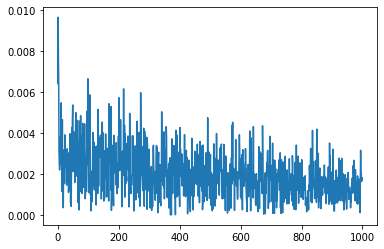

In [77]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [68]:
#output.topk(1)
all_venues.get()

torch.return_types.topk(values=tensor([[0.]], grad_fn=<TopkBackward>), indices=tensor([[5]]))

3. **Keras RNN Model with venues and time in minutes**
---
Model using Keras.
In Keras we can combine categorical and numeric features.

Idea:

we have a sequence of events (v1,t1) (v2,t2) (v3,t3) and (v4,t4)
We create two inputs v1 (categorical) and t1(numeric) pass it to a multi-input and multi-output keras model.

For each sequence we create a set of features and targets and train the model for that sequence, and then continue the same process for all sequences.


In [56]:
train_sequences_x_y

NameError: ignored

In [ ]:
#events are of the form (v,t), where v is categorical and t is hour in mins, seperate the two
#same function used for ksplit() will work

temp1 = _ksplit_x_y(X_train_features)

X_train_features_categorical = temp1[0]
X_train_features_numerical = temp1[1]

temp2 = _ksplit_x_y(Y_train_targets)

Y_train_targets_categorical = temp2[0]
Y_train_targets_numerical = temp2[1]


In [ ]:
#convert categorical to one hot encoding

def _one_hot_k(data):
  changed_data = []
  for sequence in data:
    temp = []
    for venue in sequence:
      temp.append(coded_obj.onehot_encoded(venue))
    changed_data.append(temp)
  return changed_data


In [ ]:
#replace

#X_train_features_categorical = _one_hot_k(X_train_features_categorical)
#Y_train_targets_categorical = _one_hot_k(Y_train_targets_categorical)

In [ ]:
#test2 = tf.ragged.constant(X_train_features_categorical)
#test22 = tf.ragged.constant(X_train_features_numerical)


In [ ]:

float_input = tf.keras.Input(shape=(2, ))
one_hot_input = tf.keras.Input(shape=(137,) )

first_dense = tf.keras.layers.Dense(3)(float_input)
second_dense = tf.keras.layers.Dense(50)(one_hot_input)

merge_one = tf.keras.layers.concatenate([first_dense, second_dense])
dense_inner = tf.keras.layers.Dense(10)(merge_one)

dense_output1 = tf.keras.layers.Dense(1)(dense_inner)
dense_output2 = tf.keras.layers.Dense(1)(dense_inner)

model = tf.keras.Model(inputs=[float_input, one_hot_input], outputs=[dense_output1,dense_output2])


model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

#model.summary()

#model.fit([X1,X2], Y, epochs=2)

Resources used
***
https://discuss.pytorch.org/t/mini-batch-training-for-inputs-of-variable-sizes/13662

https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed

https://stackoverflow.com/questions/53532352/how-do-i-split-the-training-dataset-into-training-validation-and-test-datasets

https://learning.oreilly.com/library/view/deep-learning-with/9781788624336/e397c9a2-28a2-41fd-bcc2-a6bb49adfc44.xhtml

https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning


https://jdhao.github.io/2017/11/15/pytorch-datatype-note/

https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm

https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

